In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss, roc_curve, auc, precision_score, \
                            recall_score

from utils import *
from utils_plotting import plot_confusion_matrix, plot_roc_curve

In [3]:
def classification_report(predictions, data_path=None):
    class_names = np.unique(predictions['CLASS'])
    predictions['class_pred'] = predictions[class_names].idxmax(axis=1)
    
    np.set_printoptions(precision=4)

    multiclass_report(predictions, class_names)
    binary_report(predictions)
    
    if data_path is not None:
        z_report(predictions, data_path)

def multiclass_report(predictions, class_names):
    print('Multiclass classification results:')
    
    y_true = predictions['CLASS']
    y_pred = predictions['class_pred']

    acc = accuracy_score(y_true, y_pred)
    print('Accuracy = {:.4f}'.format(acc))
    
    f1 = f1_score(y_true, y_pred, average=None)
    print('F1 per class = {}'.format(f1))

    cnf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

def binary_report(predictions):
    print('Binary classification results:')
    
    y_true = (predictions['CLASS'] == 'QSO')
    y_pred_proba = predictions['QSO']
    y_pred_binary = (predictions['class_pred'] == 'QSO')
    
    n_pos = y_pred_binary.sum()
    n_all = len(y_pred_binary)
    print('Predicted positives: {}/{} ({:.2f}%)'.format(n_pos, n_all, n_pos / n_all * 100))
    
    logloss = log_loss(y_true, y_pred_proba)
    print('logloss = {:.4f}'.format(logloss))
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print('ROC AUC = {:.4f}'.format(roc_auc))
    plot_roc_curve(fpr, tpr, roc_auc)
    
    binary_metrics = {
        'accuracy': accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score,
    }
    for metric_name, metric_func in binary_metrics.items():
        metric_value = metric_func(y_true, y_pred_binary)
        print('{} = {:.4f}'.format(metric_name, metric_value))
        
def z_report(predictions, data_path):
    data = process_kids(data_path, with_print=False)
    predictions = predictions.merge(data[['ID', 'Z']], how='left', on='ID')
    
    qso_correct = (predictions['CLASS'] == 'QSO') & (predictions['class_pred'] == 'QSO')
    qso_not_correct = (predictions['CLASS'] == 'QSO') & (predictions['class_pred'] != 'QSO')
    
    ds_tp = predictions.loc[qso_correct, 'Z']
    ds_fn = predictions.loc[qso_not_correct, 'Z']
    _, bin_edges = np.histogram(np.hstack((ds_tp, ds_fn)), bins=40)

    sns.distplot(ds_tp, label='TP', bins=bin_edges, kde=False, rug=False, hist_kws={'alpha': 0.5})
    sns.distplot(ds_fn, label='FN', bins=bin_edges, kde=False, rug=False, hist_kws={'alpha': 0.5})
    plt.legend()

# KiDS (mags + colors) vs. colors

In [13]:
preds_1 = pd.read_csv('experiments/KiDS_DR3_x_SDSS_DR14_cleaned_rcut__2018-03-05_14:13:44.csv')
preds_2 = pd.read_csv('experiments/KiDS_DR3_x_SDSS_DR14_cleaned_colors_cut__2018-03-05_13:59:06.csv')

In [14]:
id_intersection = np.intersect1d(preds_1['ID'], preds_2['ID'])
set_intersection = preds_1.loc[preds_1['ID'].isin(id_intersection)]
id_intersection.shape

(23188,)

In [15]:
print(np.unique(preds_1['CLASS'], return_counts=True))
print(np.unique(preds_2['CLASS'], return_counts=True))
print(np.unique(set_intersection['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([12089,  4352,  7329]))
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([12090,  4098,  7231]))
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([12071,  3911,  7206]))


/home/snakoneczny/tools/python3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Multiclass classification results:
Accuracy = 0.9417
F1 per class = [0.9696 0.8699 0.9335]


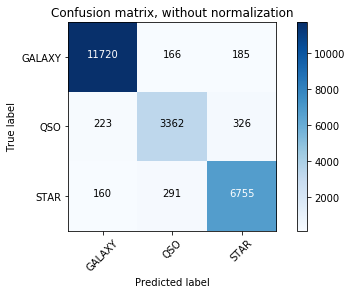

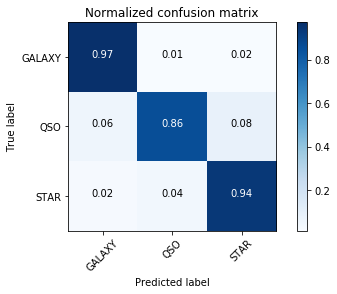

Binary classification results:
Predicted positives: 3819/23188 (16.47%)
logloss = 0.1573
ROC AUC = 0.9782


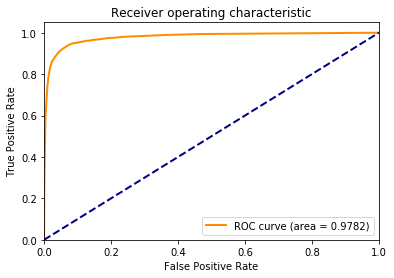

recall = 0.8596
accuracy = 0.9566
precision = 0.8803
f1 = 0.8699


In [16]:
classification_report(preds_1.loc[preds_1['ID'].isin(id_intersection)])

/home/snakoneczny/tools/python3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Multiclass classification results:
Accuracy = 0.9311
F1 per class = [0.9636 0.8473 0.9217]


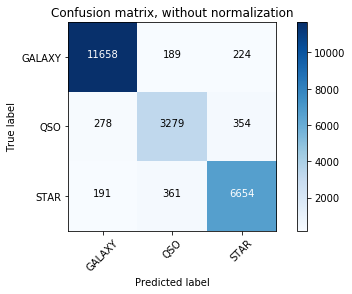

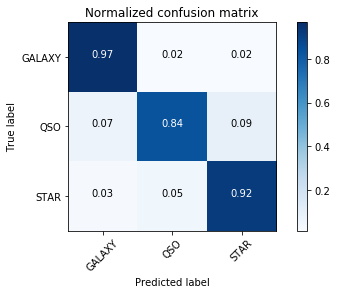

Binary classification results:
Predicted positives: 3829/23188 (16.51%)
logloss = 0.2087
ROC AUC = 0.9679


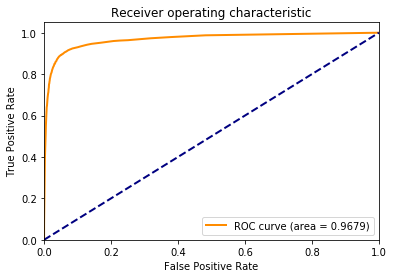

recall = 0.8384
accuracy = 0.9490
precision = 0.8564
f1 = 0.8473


In [17]:
classification_report(preds_2.loc[preds_2['ID'].isin(id_intersection)])

# KiDS, SDSS cleaned, mags + colors, R cut, all tiles

Multiclass classification results:
Accuracy = 0.9412
F1 per class = [0.9679 0.8807 0.9318]


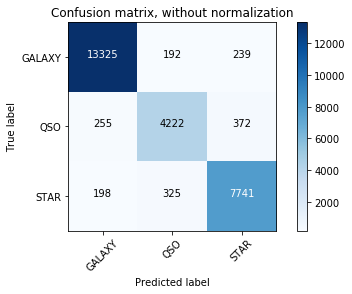

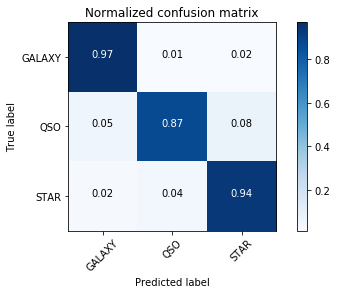

Binary classification results:
Predicted positives: 4739/26869 (17.64%)
logloss = 0.1421
ROC AUC = 0.9811


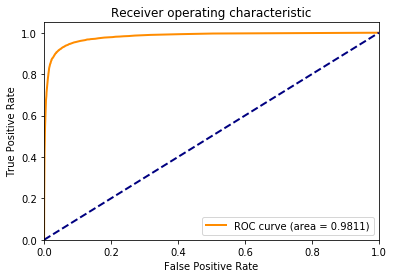

precision = 0.8909
recall = 0.8707
f1 = 0.8807
accuracy = 0.9574


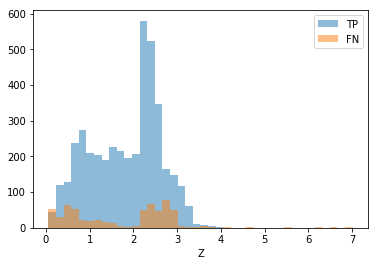

In [4]:
predictions = pd.read_csv('experiments/KiDS_DR3_x_SDSS_DR14_sdss-clean_rf_f-all_cut-r__2018-04-06_11:39:58.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.cols.csv'
classification_report(predictions, data_path)

# KiDS, SDSS cleaned, R cut

Multiclass classification results:
Accuracy = 0.9425
F1 per class = [0.9694 0.8817 0.9338]


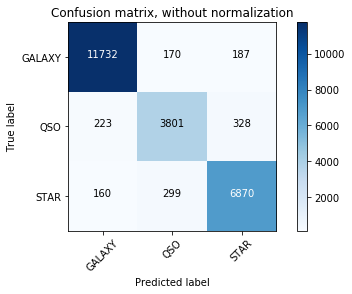

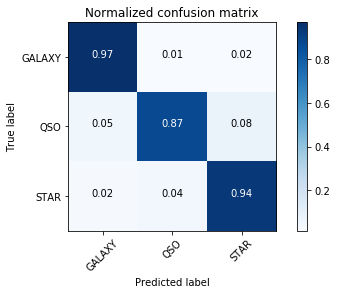

Binary classification results:
Predicted positives: 4270/23770 (17.96%)
logloss = 0.1580
ROC AUC = 0.9800


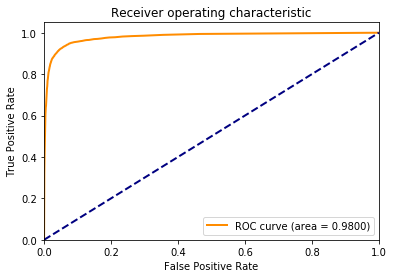

recall = 0.8734
precision = 0.8902
accuracy = 0.9571
f1 = 0.8817


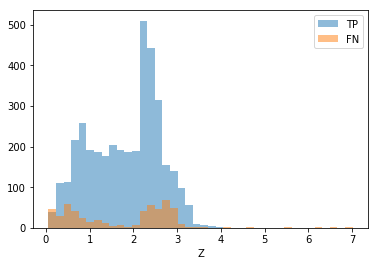

In [21]:
predictions = pd.read_csv('experiments/KiDS_DR3_x_SDSS_DR14_cleaned_rcut__2018-03-05_14:13:44.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.cols.csv'
classification_report(predictions, data_path)

# KiDS, SDSS cleaned, color cut, color features

Multiclass classification results:
Accuracy = 0.9299
F1 per class = [0.9632 0.8487 0.9196]


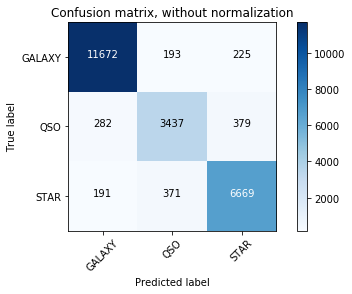

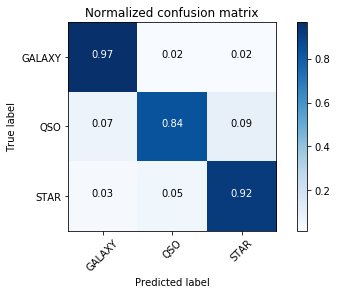

Binary classification results:
Predicted positives: 4001/23419 (17.08%)
logloss = 0.2123
ROC AUC = 0.9682


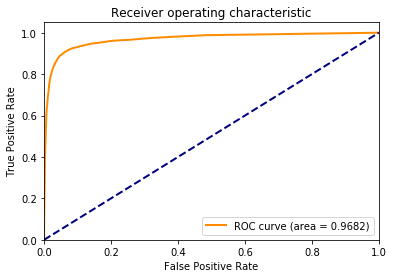

precision = 0.8590
accuracy = 0.9477
f1 = 0.8487
recall = 0.8387


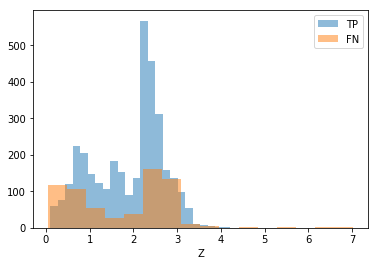

In [6]:
predictions = pd.read_csv('predictions/KiDS_DR3_x_SDSS_DR14_cleaned_colors_cut__2018-03-05_13:59:06.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.cols.csv'
classification_report(predictions, data_path)

# KiDS, SDSS cleaned

Multiclass classification results:
Accuracy = 0.9416
F1 per class = [0.9691 0.8831 0.9321]


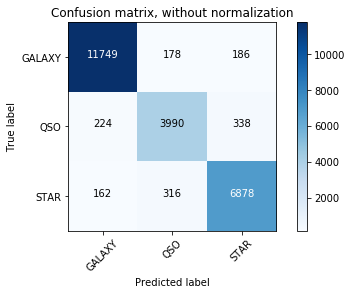

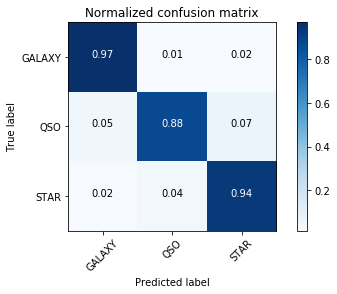

Binary classification results:
Predicted positives: 4484/24021 (18.67%)
logloss = 0.1595
ROC AUC = 0.9802


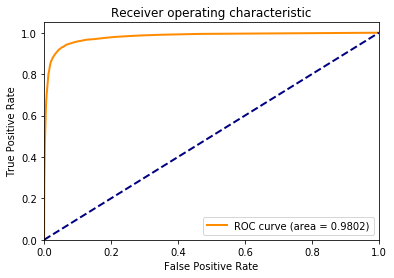

precision = 0.8898
accuracy = 0.9560
f1 = 0.8831
recall = 0.8765


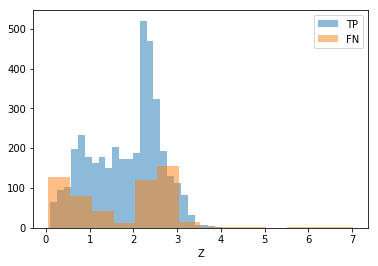

In [8]:
predictions = pd.read_csv('predictions/KiDS_DR3_x_SDSS_DR14_cleaned__2018-03-05_13:04:18.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.cols.csv'
classification_report(predictions, data_path)

# KiDS

Multiclass classification results:
Accuracy = 0.9128
F1 per class = [0.9578 0.8279 0.8988]


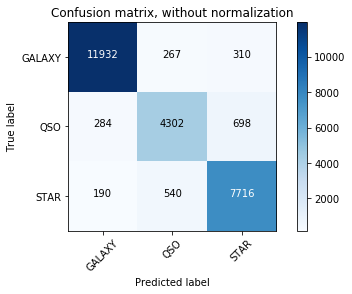

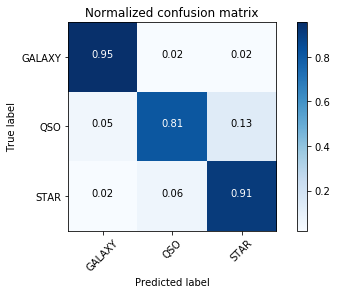

Binary classification results:
Predicted positives: 5109/26239 (19.47%)
logloss = 0.2481
ROC AUC = 0.9636


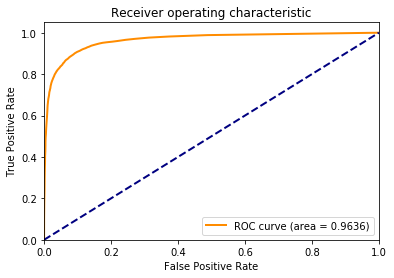

precision = 0.8420
accuracy = 0.9318
f1 = 0.8279
recall = 0.8142


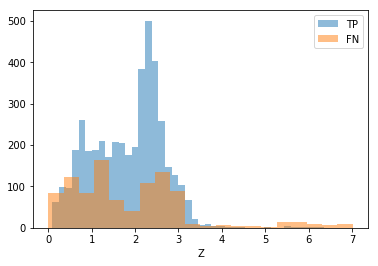

In [9]:
predictions = pd.read_csv('predictions/KiDS_DR3_x_SDSS_DR14__2018-02-27_11:33:16.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.cols.csv'
classification_report(predictions, data_path)

# KiDS x GAIA, SDSS cleaned, R band cut

Multiclass classification results:
Accuracy = 0.9486
F1 per class = [0.9516 0.9196 0.9609]


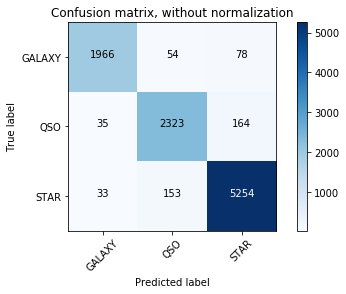

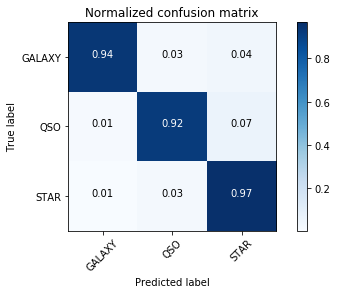

Binary classification results:
Predicted positives: 2530/10060 (25.15%)
logloss = 0.1373
ROC AUC = 0.9876


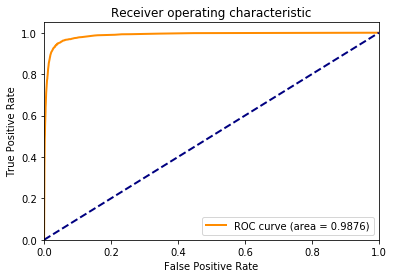

accuracy = 0.9596
recall = 0.9211
f1 = 0.9196
precision = 0.9182


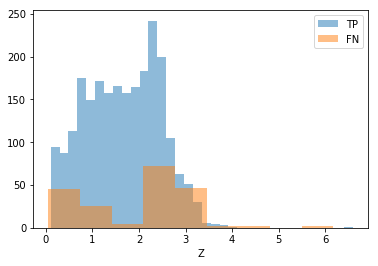

In [5]:
predictions = pd.read_csv('predictions/KiDS_DR3_x_GAIA_x_SDSS_DR14_cleaned_rcut__2018-03-08_11:34:01.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.x.SDSS.DR14.cols.csv'
classification_report(predictions, data_path)

# KiDS x GAIA, SDSS cleaned, color cut, color features

Multiclass classification results:
Accuracy = 0.9378
F1 per class = [0.9393 0.8901 0.9565]


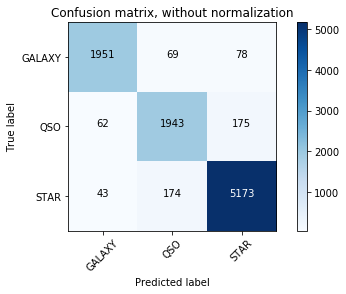

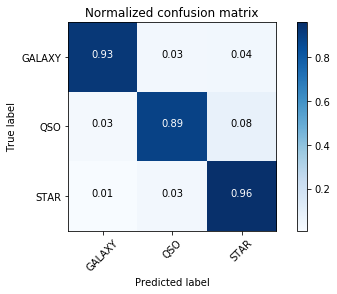

Binary classification results:
Predicted positives: 2186/9668 (22.61%)
logloss = 0.1875
ROC AUC = 0.9817


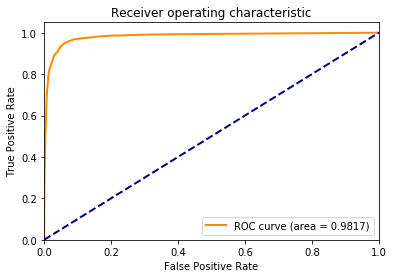

precision = 0.8888
accuracy = 0.9504
f1 = 0.8901
recall = 0.8913


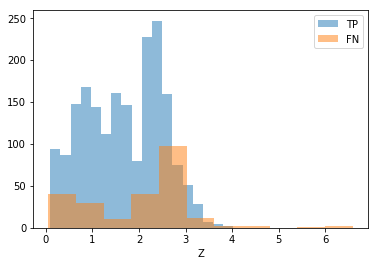

In [12]:
predictions = pd.read_csv('predictions/KiDS_DR3_x_GAIA_x_SDSS_DR14_cleaned_colors_cut__2018-03-06_15:57:41.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.x.SDSS.DR14.cols.csv'
classification_report(predictions, data_path)

# KiDS x GAIA

Multiclass classification results:
Accuracy = 0.9337
F1 per class = [0.9351 0.902  0.9481]


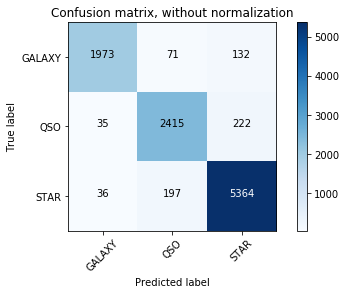

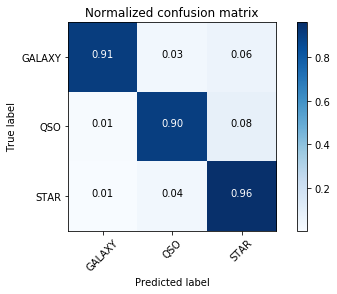

Binary classification results:
Predicted positives: 2683/10445 (25.69%)
logloss = 0.2086
ROC AUC = 0.9795


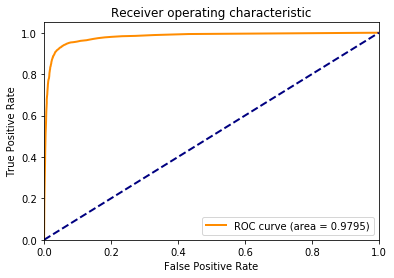

precision = 0.9001
accuracy = 0.9497
f1 = 0.9020
recall = 0.9038


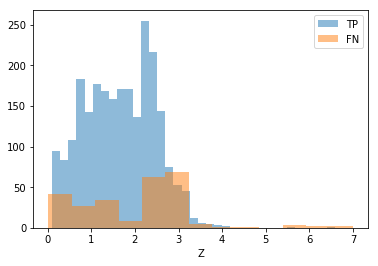

In [13]:
predictions = pd.read_csv('predictions/KiDS_DR3_x_GAIA_x_SDSS_DR14__2018-02-22_12:41:31.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.x.SDSS.DR14.cols.csv'
classification_report(predictions, data_path)

# KiDS STAR, SDSS cleaned, R band cut

Multiclass classification results:
Accuracy = 0.9368
F1 per class = [0.     0.9145 0.9529]


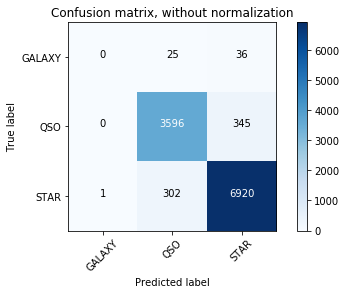

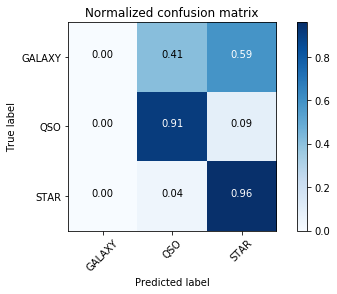

Binary classification results:
Predicted positives: 3923/11225 (34.95%)
logloss = 0.1696
ROC AUC = 0.9816


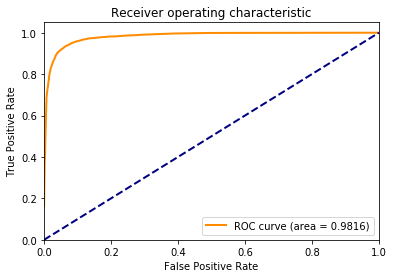

accuracy = 0.9401
recall = 0.9125
f1 = 0.9145
precision = 0.9166


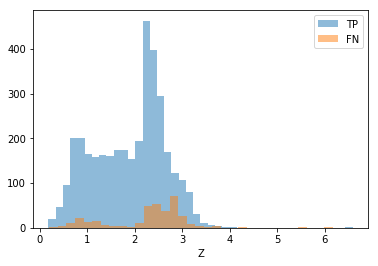

In [10]:
predictions = pd.read_csv('predictions/KiDS_DR3_STAR_x_SDSS_DR14_cleaned_rcut__2018-03-08_11:37:06.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.star.cols.csv'
classification_report(predictions, data_path)

# KiDS STAR, SDSS cleaned, color cut, color features

Multiclass classification results:
Accuracy = 0.9251
F1 per class = [0.     0.8944 0.9448]


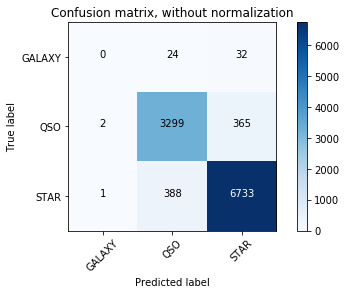

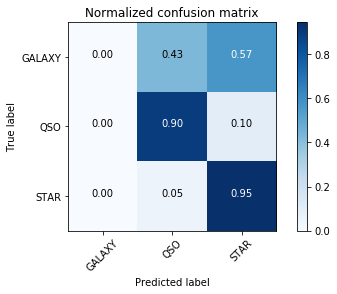

Binary classification results:
Predicted positives: 3711/10844 (34.22%)
logloss = 0.2570
ROC AUC = 0.9720


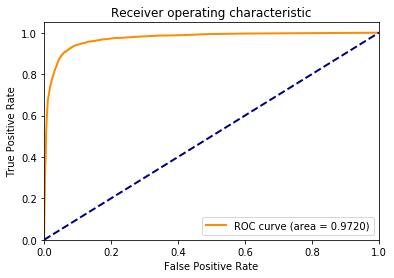

accuracy = 0.9282
recall = 0.8999
f1 = 0.8944
precision = 0.8890


FileNotFoundError: File b'/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.stars.cols.csv' does not exist

In [8]:
predictions = pd.read_csv('predictions/KiDS_DR3_STAR_x_SDSS_DR14_cleaned_colors_cut__2018-03-08_11:37:42.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.star.cols.csv'
classification_report(predictions, data_path)

# KiDS STAR

Multiclass classification results:
Accuracy = 0.8870
F1 per class = [0.0151 0.8578 0.9169]


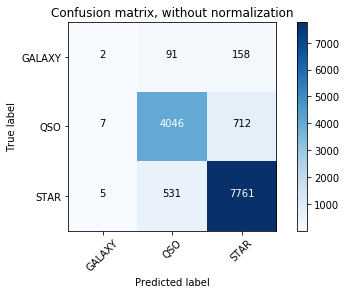

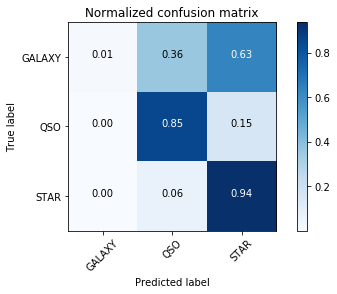

Binary classification results:
Predicted positives: 4668/13313 (35.06%)
logloss = 0.3012
ROC AUC = 0.9565


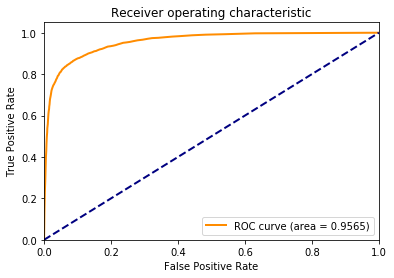

precision = 0.8668
accuracy = 0.8993
f1 = 0.8578
recall = 0.8491


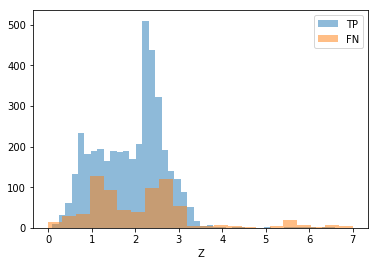

In [15]:
predictions = pd.read_csv('predictions/KiDS_DR3_STAR_x_SDSS_DR14__2018-02-22_12:42:04.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.stars.cols.csv'
classification_report(predictions, data_path)

# KiDS STAR x GAIA: two models

In [4]:
preds_gaia = pd.read_csv('predictions/KiDS_DR3_x_GAIA_x_SDSS_DR14__2018-02-22_12:41:31.csv')
preds_star = pd.read_csv('predictions/KiDS_DR3_STAR_x_SDSS_DR14__2018-02-22_12:42:04.csv')

In [5]:
id_intersection = np.intersect1d(preds_gaia['ID'], preds_star['ID'])
id_intersection.shape

(8123,)

In [6]:
print(np.unique(preds_gaia['CLASS'], return_counts=True))
print(np.unique(preds_star['CLASS'], return_counts=True))
print(np.unique(preds_gaia.loc[preds_gaia['ID'].isin(id_intersection), 'CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([2176, 2672, 5597]))
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([ 251, 4765, 8297]))
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([ 108, 2478, 5537]))


/home/snakoneczny/tools/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Multiclass classification results:
Accuracy = 0.9324
F1 per class = [0.014  0.9106 0.9539]


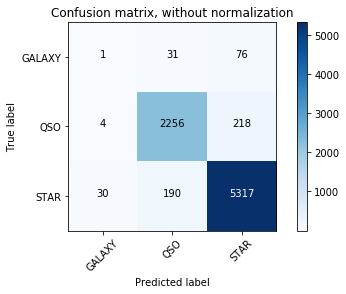

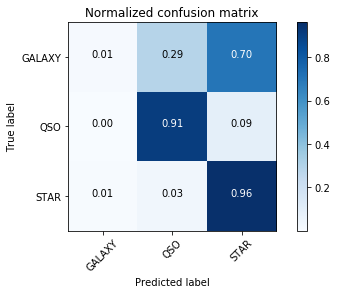

Binary classification results:
logloss = 0.2337
ROC AUC = 0.9784


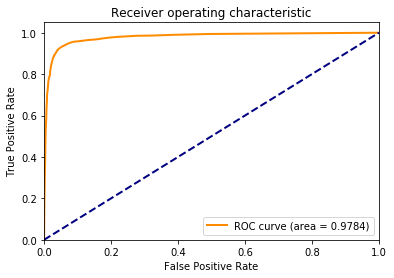

accuracy = 0.9455
f1 = 0.9106
precision = 0.9108
recall = 0.9104


In [21]:
classification_report(preds_gaia.loc[preds_gaia['ID'].isin(id_intersection)])

/home/snakoneczny/tools/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Multiclass classification results:
Accuracy = 0.9387
F1 per class = [0.018  0.9155 0.9581]


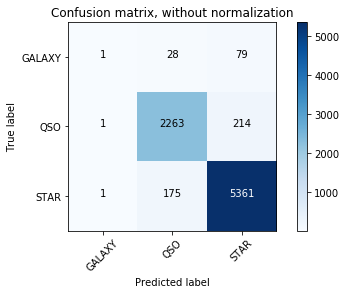

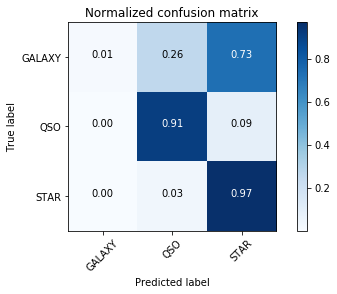

Binary classification results:
logloss = 0.2196
ROC AUC = 0.9793


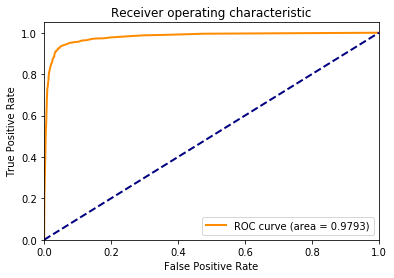

accuracy = 0.9485
f1 = 0.9155
precision = 0.9177
recall = 0.9132


In [8]:
classification_report(preds_star.loc[preds_star['ID'].isin(id_intersection)])

# Error analysis

In [4]:
predictions = pd.read_csv('predictions/KiDS_DR3_STAR_x_SDSS_DR14__2018-02-22_12:42:04.csv')

In [7]:
kids_star = process_kids('/home/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.stars.cols.csv')

Data shape: (30940, 35)
Droping NANs: 30940 left
Removing flags: 13861 left
Removing errors bigger than observations: 13857 left
Removing limiting magnitudes: 13313 left
Clean data shape: (13313, 45)


In [8]:
# Quasars and stars analysis
class_names = np.unique(predictions['CLASS'])
predictions['class_pred'] = predictions[class_names].idxmax(axis=1)

tp = predictions.loc[(predictions['CLASS'] == 'QSO') & (predictions['class_pred'] == 'QSO')]
tn = predictions.loc[(predictions['CLASS'] == 'STAR') & (predictions['class_pred'] == 'STAR')]
fp = predictions.loc[(predictions['CLASS'] == 'STAR') & (predictions['class_pred'] == 'QSO')]
fn = predictions.loc[(predictions['CLASS'] == 'QSO') & (predictions['class_pred'] == 'STAR')]

In [9]:
print(predictions.shape)
print(kids_star.shape)
print(tp.shape)
print(tn.shape)
print(fp.shape)
print(fn.shape)

(13313, 7)
(13313, 45)
(4046, 7)
(7761, 7)
(531, 7)
(712, 7)


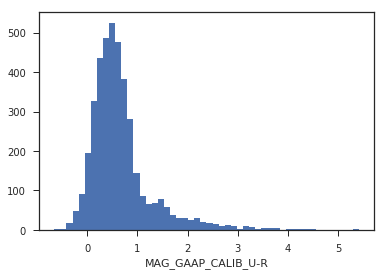

In [12]:
# Check z at the whole set and errors
sns.set(style='ticks')
sns.distplot(kids_star.loc[kids_star['ID'].isin(tp['ID']), MAG_GAAP_CALIB_UR], kde=False, rug=False, hist_kws={'alpha': 1})

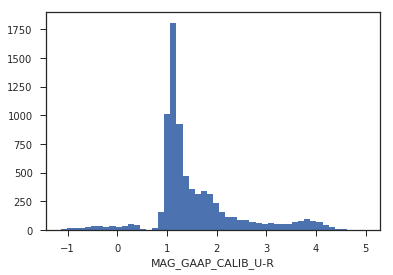

In [13]:
# Check z at the whole set and errors
sns.set(style='ticks')
sns.distplot(kids_star.loc[kids_star['ID'].isin(tn['ID']), MAG_GAAP_CALIB_UR], kde=False, rug=False, hist_kws={'alpha': 1})

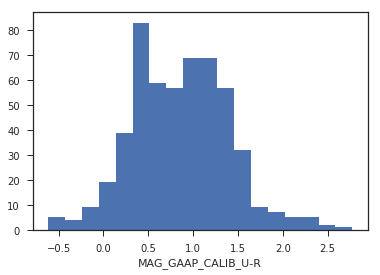

In [14]:
# Check z at the whole set and errors
sns.set(style='ticks')
sns.distplot(kids_star.loc[kids_star['ID'].isin(fp['ID']), MAG_GAAP_CALIB_UR], kde=False, rug=False, hist_kws={'alpha': 1})

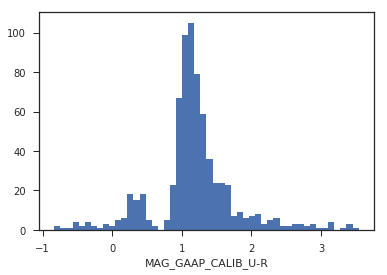

In [15]:
# Check z at the whole set and errors
sns.set(style='ticks')
sns.distplot(kids_star.loc[kids_star['ID'].isin(fn['ID']), MAG_GAAP_CALIB_UR], kde=False, rug=False, hist_kws={'alpha': 1})